# Import Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler,PowerTransformer,QuantileTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import skorch
import torch.nn.functional as F
from torch import nn
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
plt.style.use('fivethirtyeight')

# Reading data

In [3]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


In [10]:
df_train.describe()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000
mean,49999.500000,0.257830,0.431720,0.114130,0.590550,0.599770,0.160820,0.731490,1.228920,0.903350,...,0.712270,0.582070,0.529230,0.616310,0.135100,0.358660,0.516810,0.39004,0.970850,0.55712
std,28867.657797,0.929033,1.977862,0.519584,1.844558,2.785531,0.601149,2.343465,2.692732,3.415258,...,1.721863,2.003114,2.300826,2.360955,0.627592,1.464187,2.171415,1.48735,2.576615,1.68093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,24999.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
50%,49999.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
75%,74999.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.00000
max,99999.000000,10.000000,31.000000,6.000000,26.000000,38.000000,10.000000,27.000000,31.000000,39.000000,...,21.000000,32.000000,37.000000,33.000000,9.000000,26.000000,29.000000,25.00000,44.000000,20.00000


# EDA

In [32]:
order_class = ['Class_2','Class_3','Class_4','Class_1']
feature_list = []
for i in range(50):
    feature_list.append('feature_' + str(i))

In [44]:
df_train_to_scale = df_train.iloc[:,1:].copy()
scaler = QuantileTransformer()
df_train_to_scale.loc[:,feature_list]= scaler.fit_transform(df_train_to_scale.loc[:,feature_list])

dict_map = {'Class_1':0,'Class_2':1,'Class_3':2,'Class_4':3}
df_train_to_scale.target = df_train_to_scale.target.map(dict_map)
df_train_to_scale.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0.0,0.0,0.953954,0.0,0.909910,0.000000,0.0,0.000000,0.0,0.00000,...,0.0,0.417417,0.997226,0.0,0.0,0.0,0.000000,0.000000,0.0,1
1,0.0,0.0,0.000000,0.0,0.945445,0.931932,0.0,0.000000,0.0,0.00000,...,0.0,0.417417,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0
2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.82983,...,0.0,0.882883,0.000000,0.0,0.0,0.0,0.996997,0.857357,0.0,0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.862863,0.0,0.00000,...,0.0,0.417417,0.000000,0.0,0.0,0.0,0.000000,0.749249,0.0,3
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,...,0.0,0.417417,0.000000,0.0,0.0,0.0,0.000000,0.749249,0.0,1


## Plots

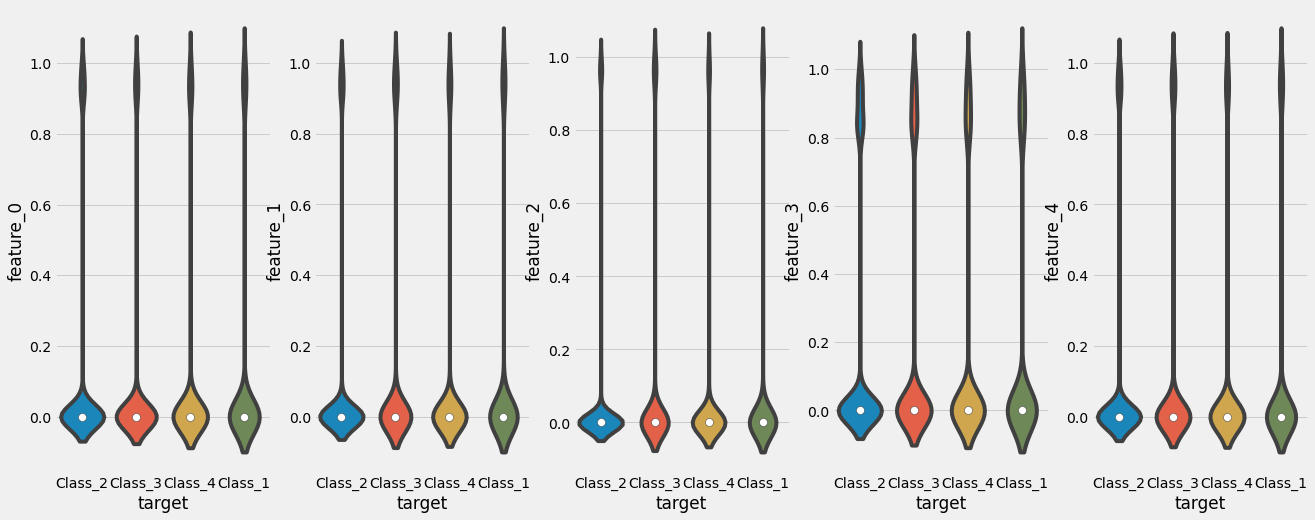

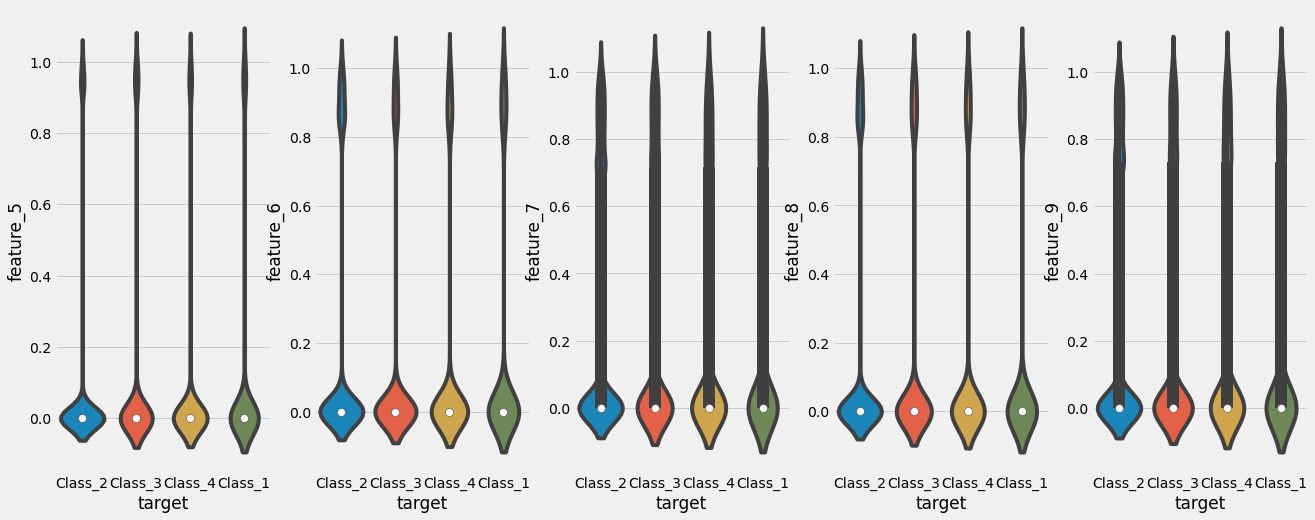

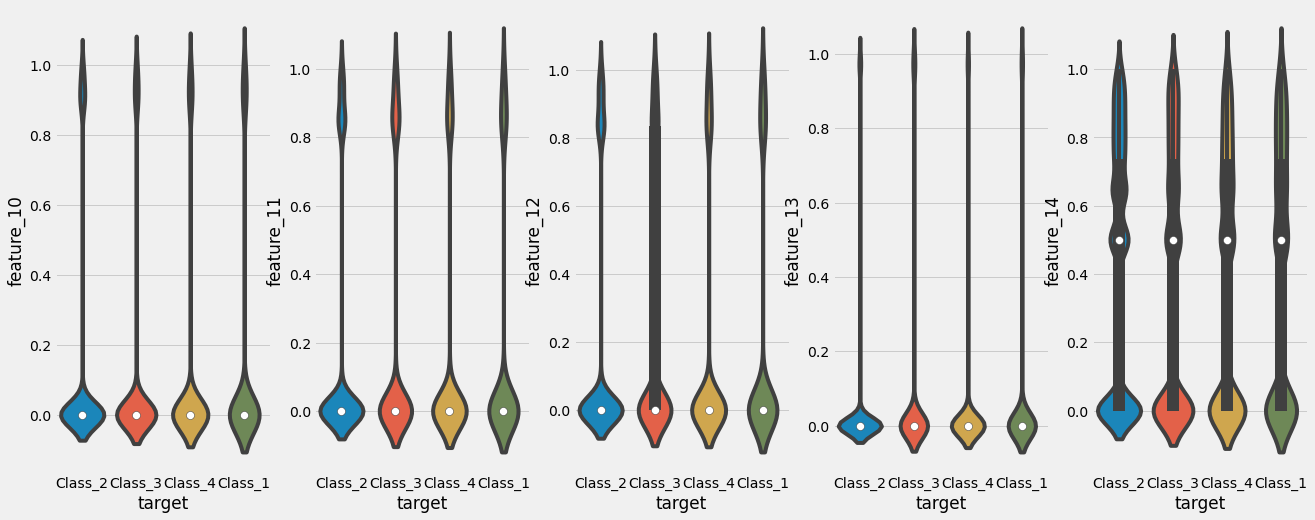

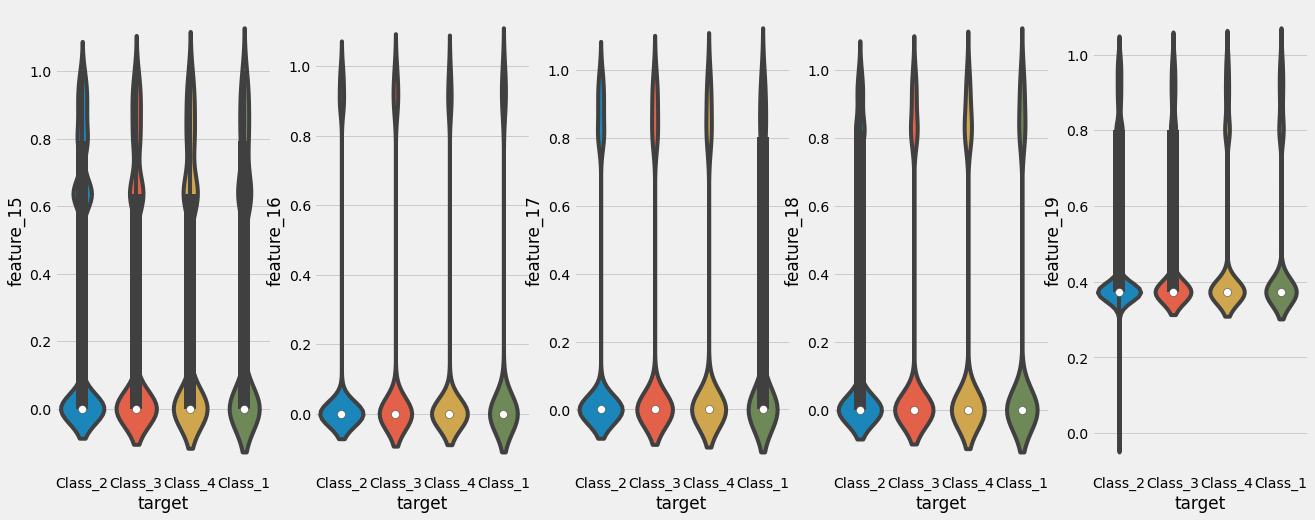

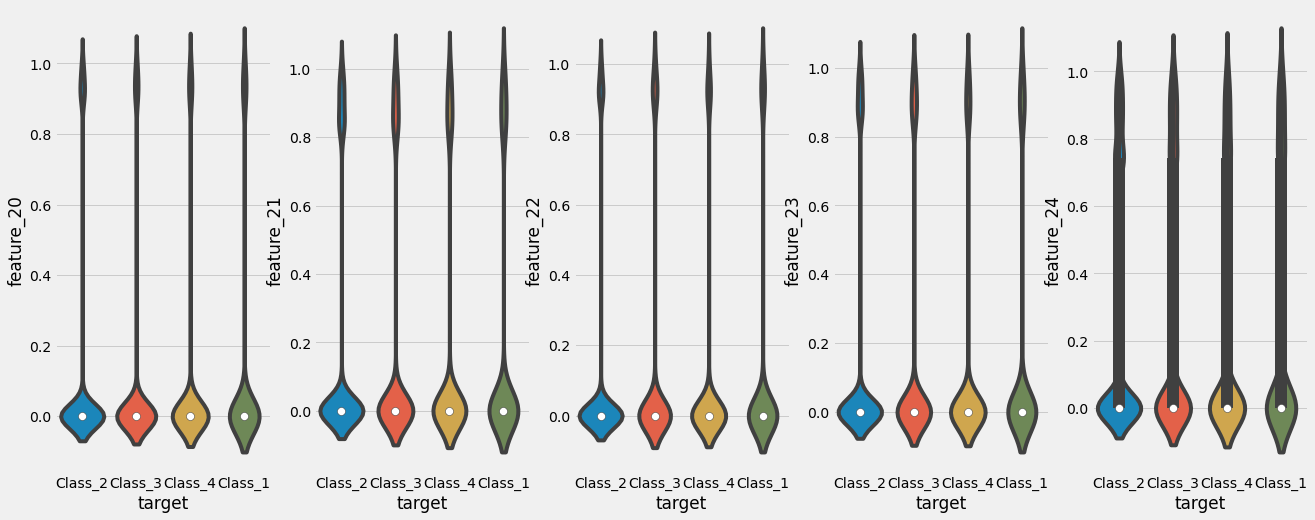

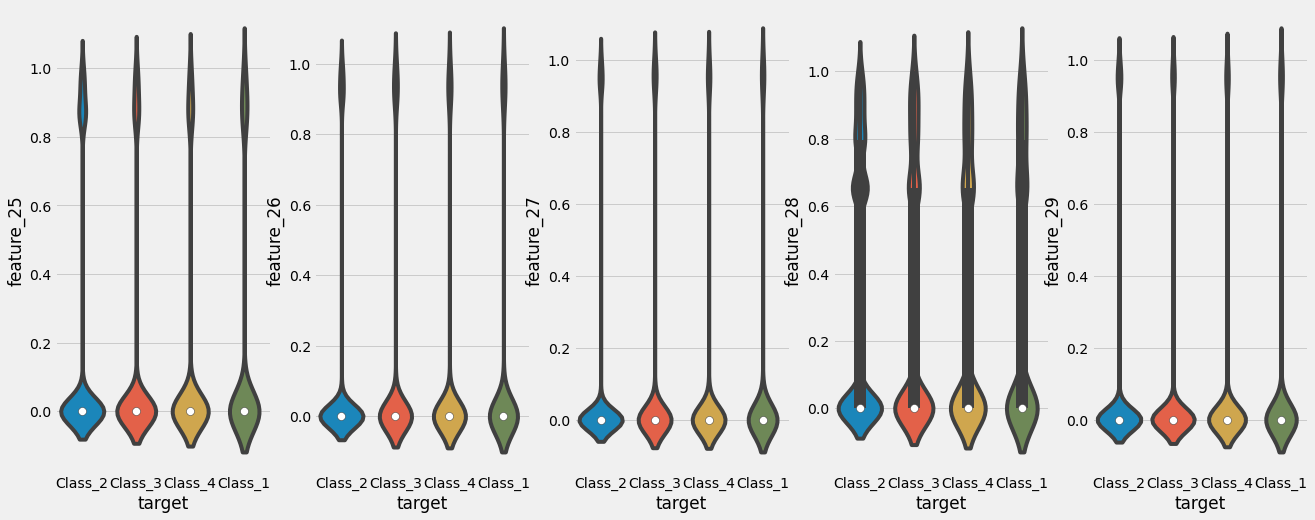

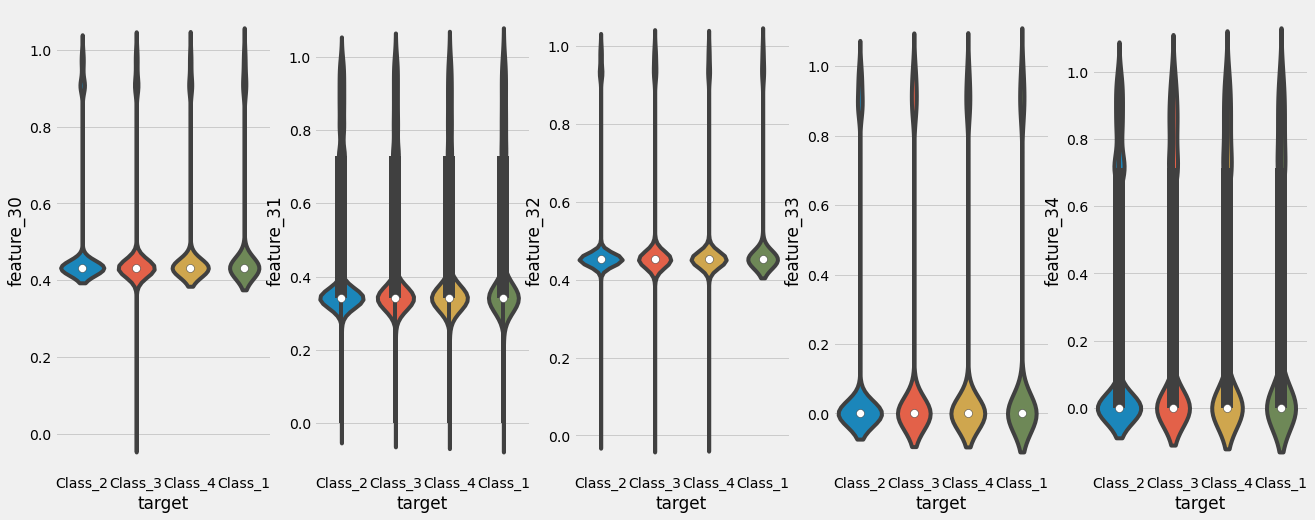

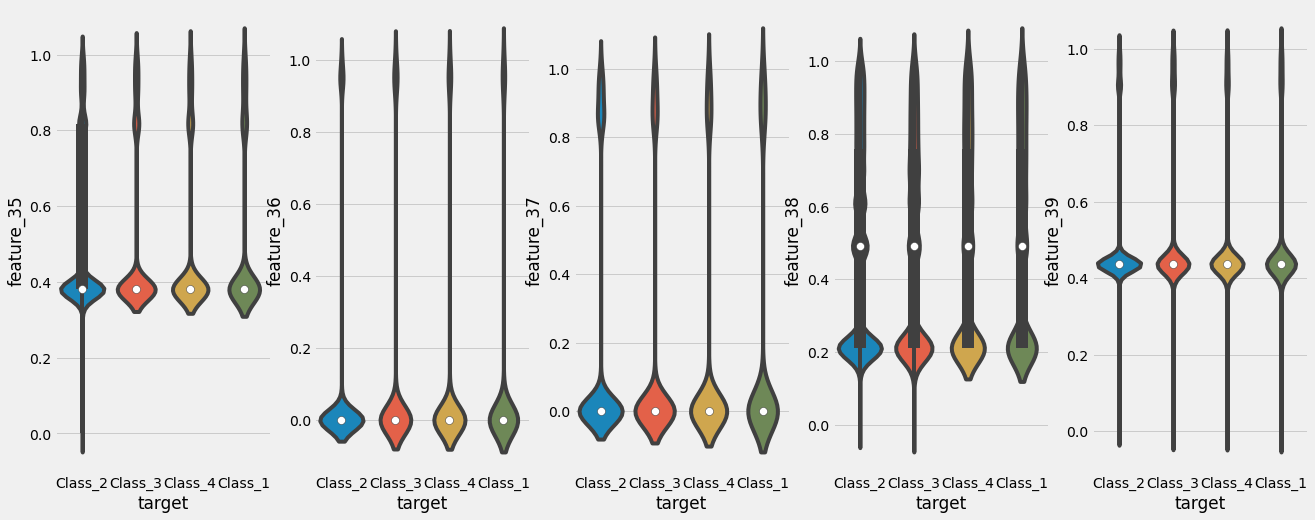

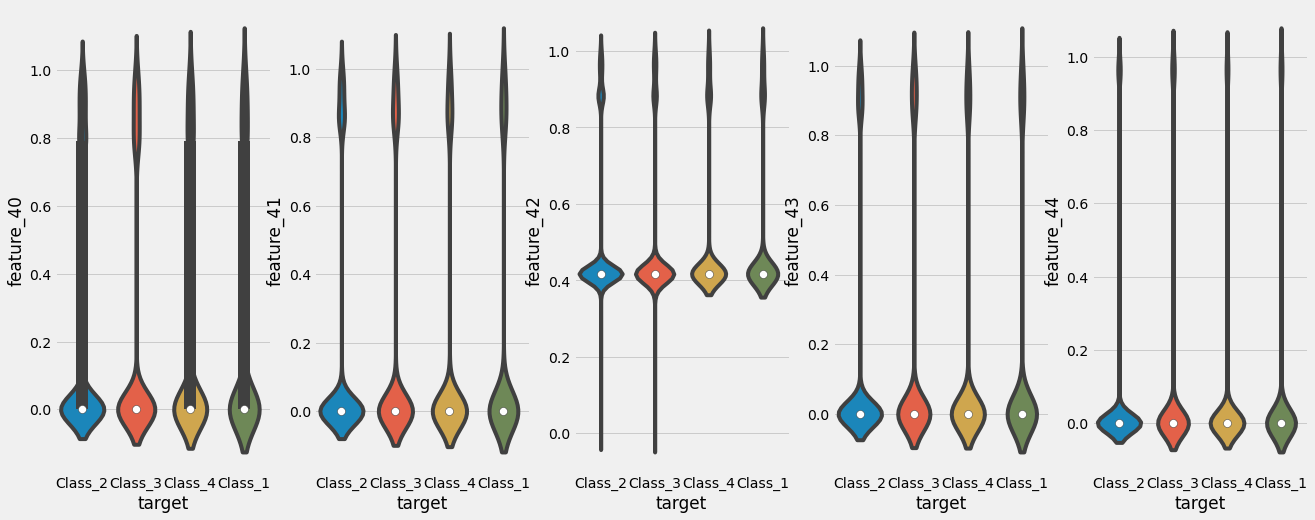

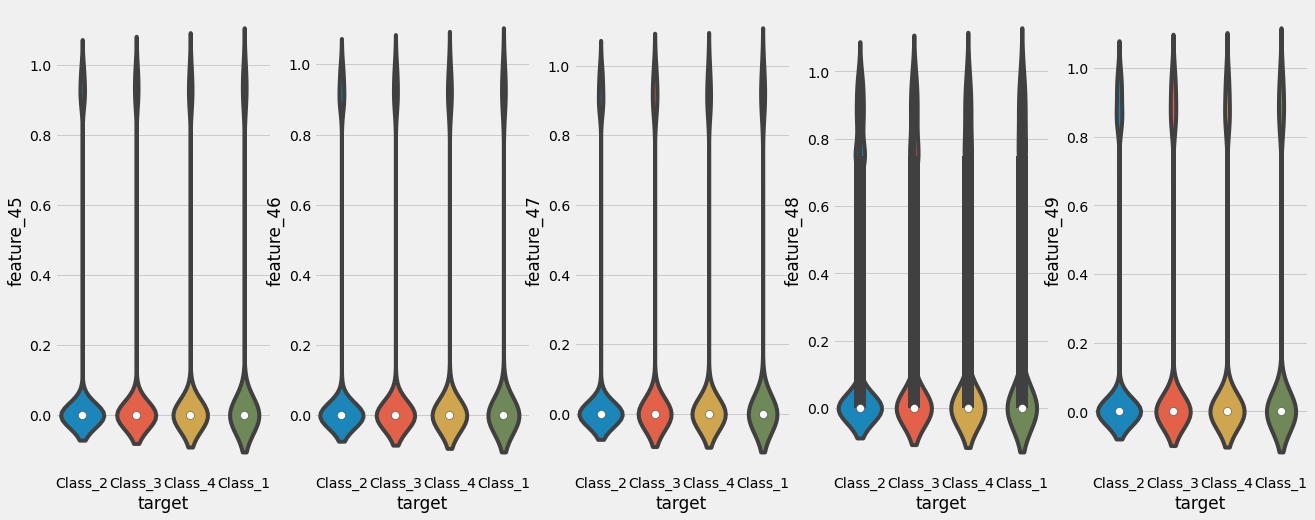

In [33]:
fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(0,5):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(5,10):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(10,15):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(15,20):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(20,25):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(25,30):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(30,35):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(35,40):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(40,45):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

fig,axs = plt.subplots(1,5, figsize = (20,8))
for i in range(45,50):
    sns.violinplot(y = 'feature_' + str(i), x= 'target', data = df_train_to_scale,order= order_class, ax = axs[i%5])
plt.show()

# Model Building

In [63]:
df_train_to_scale.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.108633,0.103829,0.062938,0.194965,0.109429,0.092765,0.172928,0.285034,0.179661,0.275997,...,0.177938,0.500043,0.144693,0.065200,0.119042,0.129281,0.136448,0.270398,0.175892,1.381160
std,0.301146,0.295719,0.238586,0.369289,0.302004,0.282290,0.356345,0.397349,0.360663,0.396180,...,0.359542,0.186497,0.335709,0.242401,0.312194,0.322168,0.328623,0.395368,0.358308,0.810891
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.417417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.417417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.717217,0.000000,0.732733,...,0.000000,0.417417,0.000000,0.000000,0.000000,0.000000,0.000000,0.749249,0.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [45]:
X_train = df_train_to_scale.iloc[:,1:-1]
y_train = df_train_to_scale.target

In [74]:
X = X_train.values.astype(np.float32)
y = y_train.values.astype(np.int64)


class MyModule(nn.Module):
    def __init__(self, num_units=128, nonlin=F.relu):
        super(MyModule, self).__init__()
        self.model = torch.nn.Sequential(nn.Linear(X_train.shape[1], num_units),nn.ReLU6(),
                                         nn.Dropout(0.3),nn.Linear(num_units, 32),
                                         nn.ReLU(),nn.Linear(32, 16),nn.ReLU(),nn.Dropout(0.2),nn.Linear(16, 4))
    def forward(self, X, **kwargs):
        X = self.model(X)
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=100,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
  criterion=torch.nn.CrossEntropyLoss,
    optimizer__weight_decay = 0.5
)
net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2597       0.5750        1.2291  1.6259
      2        1.2271       0.5750        1.2281  1.6280
      3        1.2271       0.5750        1.2270  1.5270
      4        1.2270       0.5750        1.2267  1.5094
      5        1.2267       0.5750        1.2275  1.4973
      6        1.2271       0.5750        1.2266  1.4890
      7        1.2266       0.5750        1.2280  1.5545
      8        1.2271       0.5750        1.2269  1.6171
      9        1.2269       0.5750        1.2269  1.6848
     10        1.2271       0.5750        1.2262  2.4451
     11        1.2268       0.5750        1.2269  3.7130
     12        1.2267       0.5750        1.2276  3.7013
     13        1.2272       0.5750        1.2262  2.3691
     14        1.2268       0.5750        1.2265  2.4013
     15        1.2270       0.5750        1.2259  2.6133
     16        1.2268       0.5

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (model): Sequential(
      (0): Linear(in_features=49, out_features=128, bias=True)
      (1): ReLU6()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=128, out_features=32, bias=True)
      (4): ReLU()
      (5): Linear(in_features=32, out_features=16, bias=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=16, out_features=4, bias=True)
    )
  ),
)

In [73]:
from sklearn.model_selection import GridSearchCV
params = {
    'lr': [0.01],
    'max_epochs': [500],
}
gs = GridSearchCV(net, params, refit=True, cv=5, scoring='neg_log_loss', verbose= 3, n_jobs = -1)
gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1775       0.5750        1.1223  1.5068
      2        1.1200       0.5750        1.1185  1.5078
      3        1.1190       0.5750        1.1181  1.5306
      4        1.1186       0.5750        1.1180  1.4941
      5        1.1186       0.5750        1.1179  1.4940
      6        1.1186       0.5750        1.1179  1.5119
      7        1.1185       0.5750        1.1178  1.4968
      8        1.1184       0.5750        1.1177  1.4943
      9        1.1182       0.5750        1.1176  1.4958
     10        1.1180       0.5750        1.1175  1.4943
     11        1.1179       0.5750        1.1174  1.4940
     12        1.1175       0.5750        1.1172  1.5117
     13        1.1175       0.5750        1.1170  1.4959
     14        1.1176       0.5750        1.1168  1.5051
     15        1.1171       0